# EDA for AQI india:

- Data only for 2024.
- We have some missing values as well, need to trim a bit.
We can decide what to do later with those.  
- Very large variability in January 50-350 on average.

TO DO:

- Variance could also be interesting, within January.
- Some time series of different months in the year? Could also be interesting.

## Cleaning:

In [1]:
import os
import pandas as pd
import numpy as np
# Some plotting libs
import matplotlib.pyplot as plt
import seaborn as sns
from pySankey.sankey import sankey

In [2]:
# Move to the github folder level for the current directory
os.chdir("..")
 

In [3]:
df = pd.read_csv("DATA_INDIA/aqi/aqi_india_cities_2024",usecols=[1,2,3,4,5])
df

,date,month,aqi,city,state
0,1,January,NaN,naharlagun,arunachal pradesh
1,2,January,NaN,naharlagun,arunachal pradesh
2,3,January,NaN,naharlagun,arunachal pradesh
3,4,January,NaN,naharlagun,arunachal pradesh
4,5,January,NaN,naharlagun,arunachal pradesh
...,...,...,...,...,...
104899,27,December,NaN,kohima,nagaland
104900,28,December,NaN,kohima,nagaland
104901,29,December,NaN,kohima,nagaland
104902,30,December,NaN,kohima,nagaland


In [4]:
# We want to count the missing values to see if there is some pattern or if it just random.
missing_aqi = df["aqi"].isna().rename("missing_aqi")

df = pd.concat([df,missing_aqi],axis=1)
df

,date,month,aqi,city,state,missing_aqi
0,1,January,NaN,naharlagun,arunachal pradesh,True
1,2,January,NaN,naharlagun,arunachal pradesh,True
2,3,January,NaN,naharlagun,arunachal pradesh,True
3,4,January,NaN,naharlagun,arunachal pradesh,True
4,5,January,NaN,naharlagun,arunachal pradesh,True
...,...,...,...,...,...,...
104899,27,December,NaN,kohima,nagaland,True
104900,28,December,NaN,kohima,nagaland,True
104901,29,December,NaN,kohima,nagaland,True
104902,30,December,NaN,kohima,nagaland,True


In [5]:
# Get monthly averages.

df_monthly = df.groupby(["month","city","state"],as_index=False)[["aqi","missing_aqi"]].mean()

In [6]:
df_monthly

,month,city,state,aqi,missing_aqi
0,April,agra,uttar pradesh,70.033333,0.032258
1,April,ahmedabad,gujarat,119.933333,0.032258
2,April,aizawl,mizoram,84.000000,0.096774
3,April,ajmer,rajasthan,95.600000,0.032258
4,April,akola,maharashtra,85.600000,0.032258
...,...,...,...,...,...
3379,September,virudhunagar,tamil nadu,32.240000,0.193548
3380,September,visakhapatnam,andhra pradesh,90.137931,0.064516
3381,September,vrindavan,uttar pradesh,75.076923,0.161290
3382,September,yadgir,karnataka,43.310345,0.064516


In [7]:
df_monthly['month'].value_counts()

month
April        282
August       282
December     282
February     282
January      282
July         282
June         282
March        282
May          282
November     282
October      282
September    282
Name: count, dtype: int64

In [8]:
# For nicer plots.
months_categories = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

df_monthly["month"] = pd.Categorical(df_monthly["month"], categories = months_categories)

df_monthly.sort_values(by = ["month","city"]).reset_index(inplace=True)

In [9]:
# Why are there nan? From the original data... 30 cities not there.
# Drop is needed for sankey plot, if not, do not do it as it will be eliminating a few cities.

#df_monthly = df_monthly.dropna()#

# Plotting:

## Plot 1: Crossectional distribution -across cities- and months of the year.

If we want to understand differences in the AQI (Air Quality Index) we must first understand the distribution of the AQI itself. Because our data is at a daily frequency, we take a montly average. Therefore, an observation in the plot is a mean of aqi within a given month for a given indian city.

We see 3 key facts:

- There are large seasonal differences, the winter months have a worse (higher) AQI. This points to seasonal patterns being important, it could be weather factors, seasonal patterns related to farmers, like burning crops, amongst others. 

- There is also a large seasonal pattern in the variance of the distribution. In the winter months the distribution becomes much more spread out, the differences between the 25th and 75th quantiles are of 100 points. This difference is reduced to less than 50 points in the summer months. In other ways, the seasonal differences not only make the distribution shift down, they also make it more and less spread out. This seems to point to some important nonlinearities, it seems for example, that an improvement in weather conditions will not have the same effects in all cities. This is something we will have to keep in mind in our statistical analysis.    

- In all months there are extreme values relative to the rest of the distribution. Some cities have very good (low) AQI while some have extremely bad (high)
 AQI, in our analysis we will try to understand these differences.

*Technical note:* We use this boxenplot as a good middle ground between a violintplot and a simple box plot. The violinplot uses kernel density estimates which have the undesirable properties - like going beyond the reasonable domain; in our case it gave AQI index values below 0 - and a simple boxplot which conveys less information. 
Data for December 2024 was not yet available when the data was downloaded.


**Fix the title closer to image, also change size of labels**

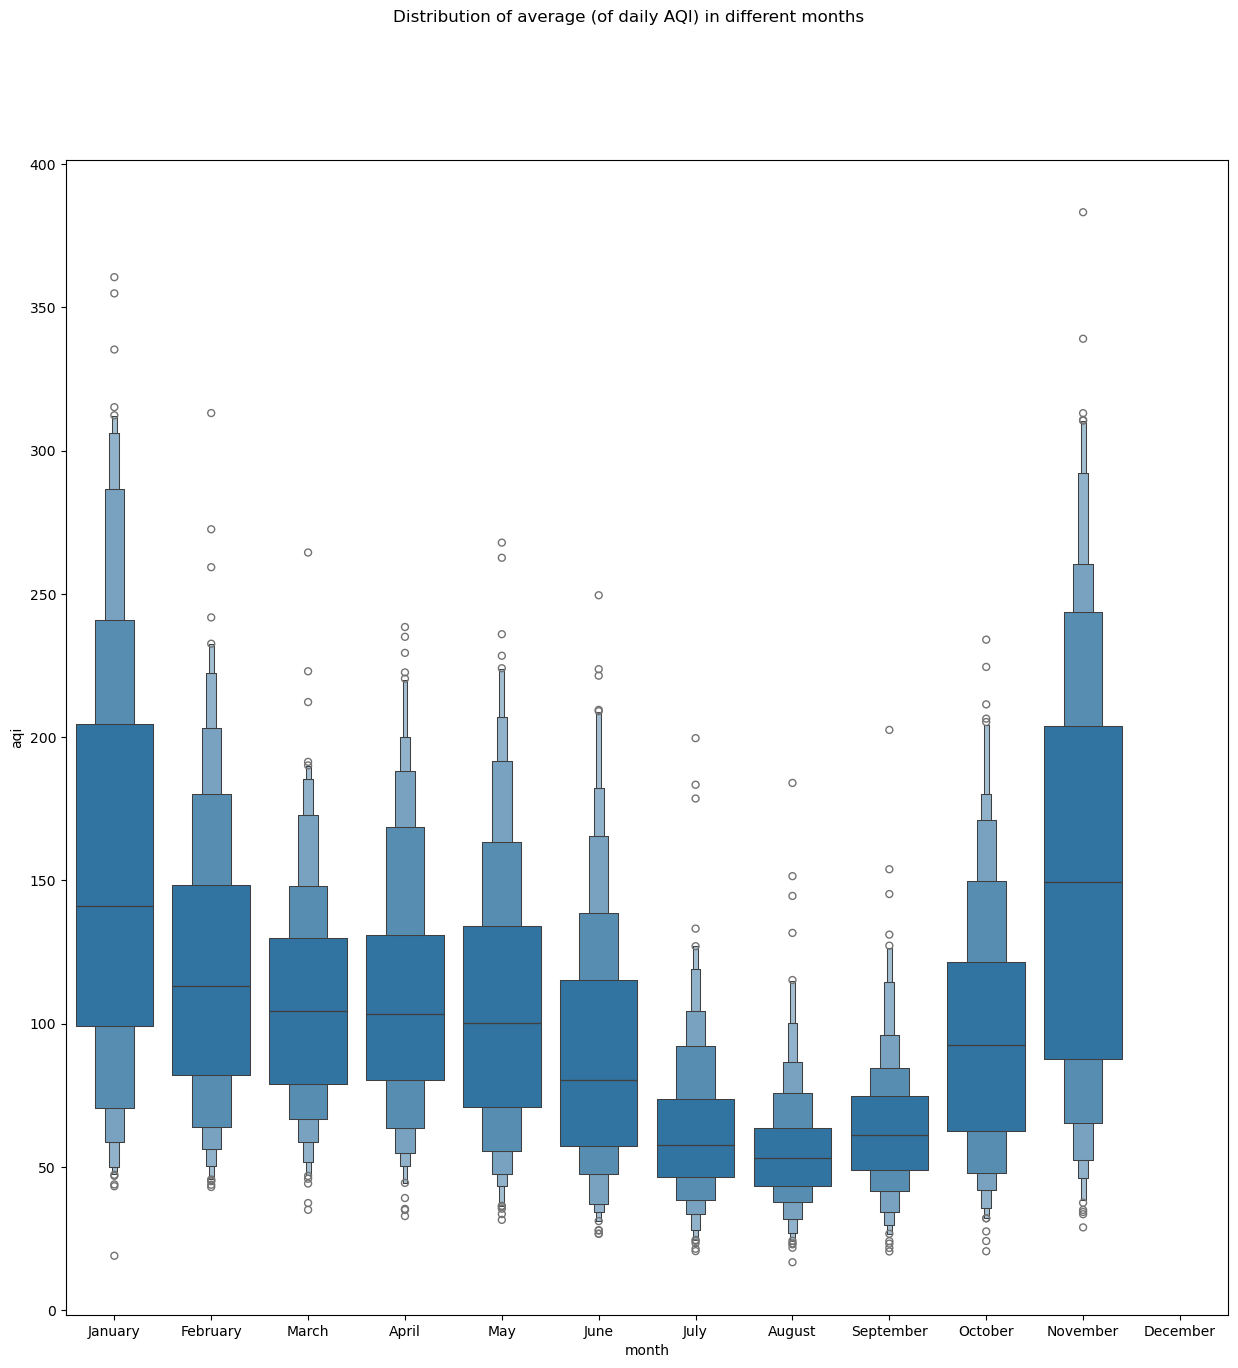

In [10]:
fig, ax = plt.subplots(figsize=(15, 15))

ax = sns.boxenplot(data=df_monthly, x="month", y="aqi")

fig.suptitle("Distribution of average (of daily AQI) in different months")
plt.show()

## Plot 2: Time series variation.

We want to understand the time series variation of different cities across time. To simplify our analysis we will concentrate on a given month. To see if that month
is representative of the whole year we will check if the ordering of the aqi is preserved across months.

https://medium.com/@cbkwgl/sankey-diagrams-in-python-fc9673465ccb

df_aqi_quantile = pd.concat([df_monthly[df_monthly["month"]=="January"]["city"],
                             pd.qcut(df_monthly[df_monthly["month"]=="January"]["aqi"],5,labels=[1,2,3,4,5]
                                    )],axis=1).rename(
                                                        columns = {"aqi": "aqi_January"}
    )
Exclude january and december
for month in months_categories[1:-1]:

    month = pd.concat([df_monthly[df_monthly["month"]==month]["city"],pd.qcut(df_monthly[df_monthly["month"]==month]["aqi"],5,labels=[1,2,3,4,5])],axis=1).rename(
        columns = {"aqi": f"aqi_{month}"}
    )
    
    df_aqi_quantile = pd.merge(df_aqi_quantile,month,on="city")

sort_for_pretty_plot = df_aqi_quantile.columns.to_list()[1:]

df_aqi_quantile = df_aqi_quantile.sort_values(by=sort_for_pretty_plot)

sankey( df_aqi_quantile["aqi_January"], df_aqi_quantile["aqi_February"], aspect=20, fontsize=12)
sankey( df_aqi_quantile["aqi_February"], df_aqi_quantile["aqi_March"], aspect=20, fontsize=12)

## Plot 3: Some State stuff

## January basics:

In [11]:
df_jan = df_monthly[df_monthly["month"]=="January"]

In [12]:
df_jan

,month,city,state,aqi,missing_aqi
1128,January,agra,uttar pradesh,121.258065,0.000000
1129,January,ahmedabad,gujarat,133.483871,0.000000
1130,January,aizawl,mizoram,43.275862,0.064516
1131,January,ajmer,rajasthan,111.774194,0.000000
1132,January,akola,maharashtra,135.193548,0.000000
...,...,...,...,...,...
1405,January,virudhunagar,tamil nadu,61.157895,0.387097
1406,January,visakhapatnam,andhra pradesh,193.607143,0.096774
1407,January,vrindavan,uttar pradesh,77.642857,0.096774
1408,January,yadgir,karnataka,90.034483,0.064516


In [13]:
df_jan.isna().sum()

month           0
city            0
state           0
aqi            17
missing_aqi     0
dtype: int64

In [130]:
#df_jan.to_csv("DATA_INDIA/aqi/aqi_jan.csv")

<Axes: xlabel='aqi', ylabel='missing_aqi'>

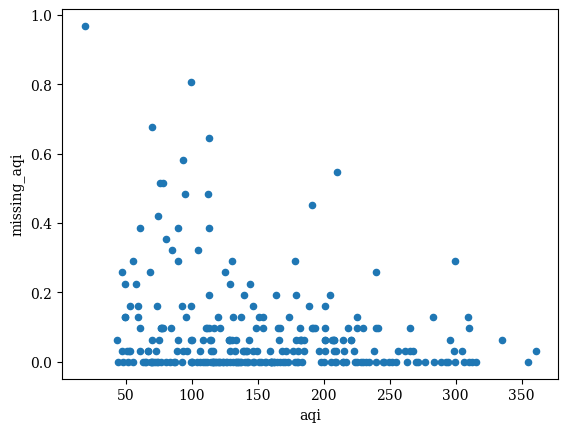

In [131]:
df_jan[["aqi","missing_aqi"]].plot.scatter(x= "aqi",y = "missing_aqi")

<Axes: >

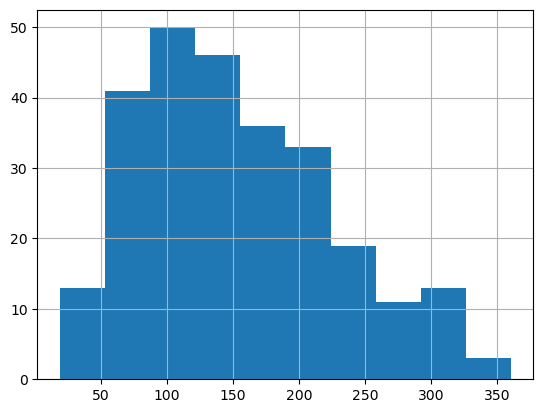

In [49]:
df_jan["aqi"].hist()
# Not needed as it is in the first plot.

## By state:


In [147]:
# This could be somthing nice to plot geographically

df_jan.groupby("state")["aqi"].mean().sort_values(ascending=False)

state
delhi                354.838710
himachal pradesh     298.766667
chandigarh           289.225806
bihar                227.372241
odisha               207.232861
west bengal          203.137137
rajasthan            196.084606
assam                189.857048
jharkhand            189.085714
haryana              177.193706
uttar pradesh        173.982931
uttarakhand          173.480600
punjab               148.277410
maharashtra          142.334509
madhya pradesh       139.413775
gujarat              111.773422
manipur              110.258065
andhra pradesh       108.428128
nagaland             100.354839
chhattisgarh          98.811884
telangana             92.612903
arunachal pradesh     89.454545
kerala                81.250413
tamil nadu            80.708093
karnataka             77.650434
puducherry            75.620690
meghalaya             72.419355
sikkim                48.258065
mizoram               43.275862
Name: aqi, dtype: float64

In [139]:
df_jan.groupby("state")["aqi"].describe()


,count,mean,std,min,25%,50%,75%,max
state,,,,,,,,
andhra pradesh,8.0,108.428128,57.028618,53.307692,71.528226,76.630952,151.793846,193.607143
arunachal pradesh,1.0,89.454545,NaN,89.454545,89.454545,89.454545,89.454545,89.454545
assam,6.0,189.857048,110.587779,49.296296,93.216630,234.691324,264.987903,299.318182
bihar,21.0,227.372241,72.811416,89.947368,179.080000,218.607143,283.709677,360.500000
chandigarh,1.0,289.225806,NaN,289.225806,289.225806,289.225806,289.225806,289.225806
chhattisgarh,8.0,98.811884,23.875354,66.633333,89.242742,95.215278,104.959677,142.967742
delhi,1.0,354.838710,NaN,354.838710,354.838710,354.838710,354.838710,354.838710
gujarat,7.0,111.773422,63.678445,19.000000,84.375973,106.322581,131.391935,225.555556
haryana,24.0,177.193706,53.089387,110.535714,140.119612,166.534483,209.469132,292.516129


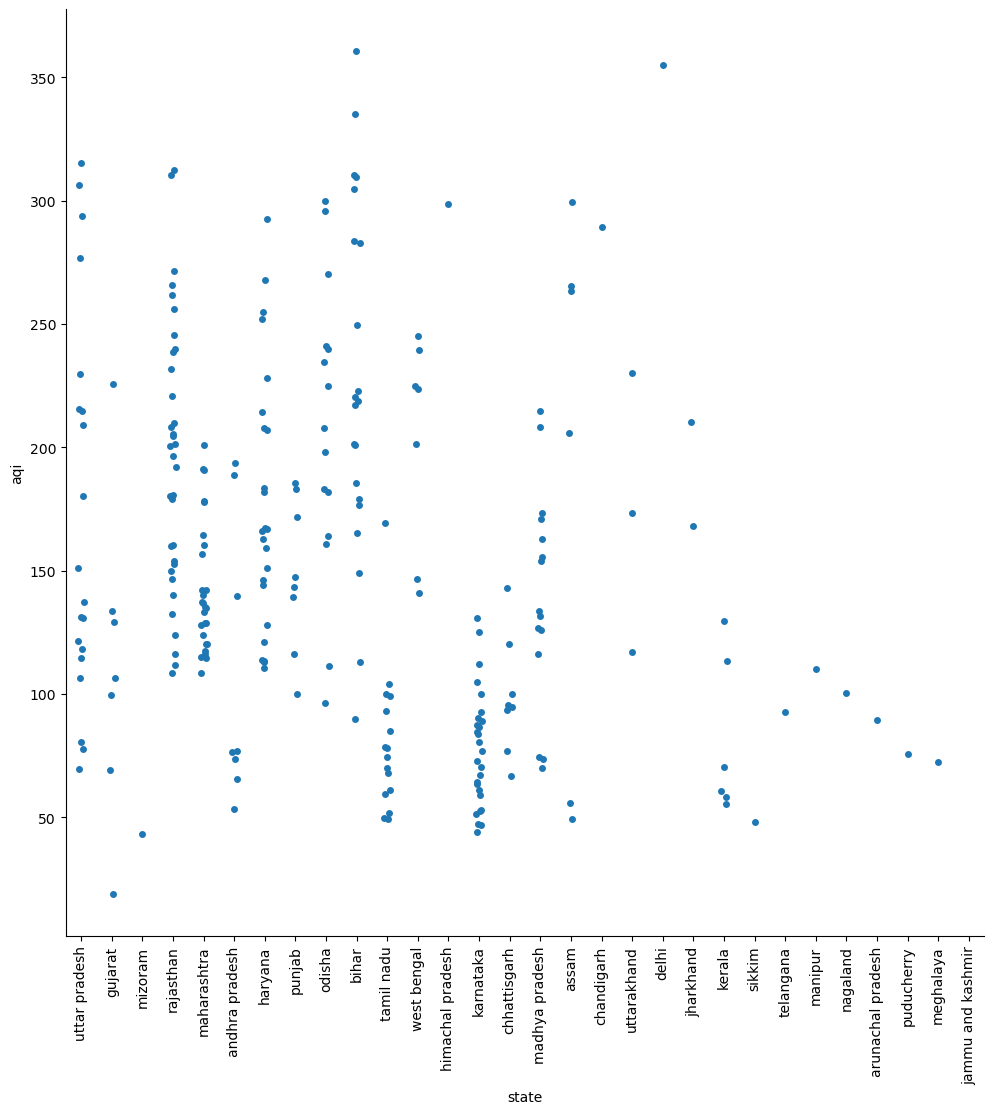

In [64]:
state_catplot = sns.catplot(data=df_jan, x="state", y="aqi",height=10)
state_catplot.set_xticklabels(rotation=90)
